## Project Description:

This notebook focuses on predictive maintenance in industrial settings using machine learning techniques. The objective is to develop a binary classification model capable of predicting machine failures. Leveraging various features such as temperature, rotational speed, torque, and tool wear, the model aims to accurately classify whether a machine is likely to experience failure or not. By employing advanced algorithms and robust evaluation methodologies, the notebook seeks to provide actionable insights for proactive maintenance strategies, ultimately enhancing operational efficiency and reducing downtime in industrial processes.

## Project Objective:

The primary goal of this notebook is to develop a robust binary classification model for predictive maintenance. The model will leverage historical data on machine performance and failure events to predict whether a machine is likely to fail in the future.

Data Preprocessing: Prepare the dataset by cleaning, transforming, and encoding features to ensure compatibility with machine learning algorithms.

Feature Engineering: Extract meaningful features and engineer new ones to capture important patterns and relationships in the data, enhancing predictive performance.

`Model Training: Implement and fine-tune various machine learning algorithms, including logistic regression, random forest, and gradient boosting, to develop a predictive binary classification model.`

`Model Evaluation: Evaluate the performance of the trained models using appropriate metrics such as accuracy, precision, recall, F1 score, and ROC AUC score. Employ cross-validation techniques to ensure robustness and generalization.`

Model Deployment: Deploy the best-performing model to production or integrate it into existing systems for real-time prediction of machine failures. Provide recommendations for proactive maintenance actions based on model insights.

By achieving these objectives, the notebook aims to empower industrial stakeholders with predictive analytics capabilities, enabling them to anticipate and mitigate potential machine failures, optimize maintenance schedules, and improve overall operational efficiency.

In [54]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, fbeta_score, recall_score, precision_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [44]:
# import sys
# sys.path.append(r'C:\Users\USER\Documents\Python Scripts\Machine learning\Neural networks\Predictive Maintenance\predictive-maintenance-supervised-learning\scripts')
#   # Add the directory containing training and evaluation scripts to Python path

# from model_training import fit_models, tune_and_fit
# from  model_evaluation import eval_preds,  predict_and_evaluate

In [45]:
# Load processed data for model training and evaluation(binary)

import joblib

# Load resampled data for Machine Failure
X_res_mf, y_res_mf = joblib.load(r'C:\Users\USER\Documents\Python Scripts\Machine learning\Neural networks\Predictive Maintenance\predictive-maintenance-supervised-learning\data\resampled_machine_failure.pkl')


## Binary task ¶

###  Preliminaries 

The goal of this section is to find the best model for binary classification of the dataset to predict whether or not there will be Machine Failure. Classification algorithms are part of data mining and use supervised machine learning methods to make predictions about data. In particular, a set of data already divided (”labeled”) into two or more classes of belonging is provided as input thanks to which a classification model is created, which will than be used on new (”unlabeled”) data to assign them to the appropriate class. The starting dataset is usually divided into three groups: the training dataset, i.e. the sample of data used to fit the model, the validation dataset, i.e. the sample of data used to provide an evaluation of a model fit on the training dataset while tuning model hyperparameters and the test dataset, which has the purpose of testing the model. At the beginning of a project a data scientist must make this division and the common ratios used are:

70% train, 15% val, 15% test.

80% train, 10% val, 10% test.

60% train, 20% val, 20% test.

In this project we use the ratio (80/10/10) for the split because we test the model for all of these strategies and find that it is the best one. The classification techniques we choose to implement are the following:

- Logistic Regression: it estimates the probability of a dependent variable as a function of independent variables. The dependent variable is the output that we are trying to predict while the independent variables or explanatory variables are the factors that we feel could influence the output. For its simplicity and interpretability, we decide to use Logistic Regression as a Benchmark model, a basic model that represents the starting point
for comparing the results obtained from other models.

- K-nearest neighbors (K-NN): algorithm based on the calculation of the distance between the elements of the dataset. Data is assigned to a certain class if close enough to the other data of the same class. Parameter K represents the number of neighboring data taken into account when assigning classes.

- Support Vector Machine: its aim is to find a hyperplane in an N-dimensional space (N—the number of features) that distinctly classifies the data points while maximizing the margin distance, i.e. the distance between data points of both classes.
Random Forest: it uses ensemble learning, which is a technique that combines many classifiers to provide solutions to complex problems. Random Forest uses bagging technique: it constructs a multitude of decision trees in parallel, all with the same importance, and the output is the class selected by most trees.

- XGBoost: is a gradient-boosted decision tree (GBDT) machine learning library. A Gradient Boosting Decision Tree (GBDT) is a decision tree ensemble learning algorithm similar to Random Forest, from which differs because it uses a boosting technique: it iteratively trains an ensemble of shallow decision trees, with each iteration using the error residuals of the previous model to fit the next model. The final prediction is a weighted sum of all of the tree predictions.

In [46]:
# train-validation-test split
X, y = X_res_mf, y_res_mf
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11, stratify=y_trainval, random_state=0)

### Feature selection attempts 

Before going into the training of the models just mentioned we try to perform feature selection, exploiting the considerations  made about the correlation heatmap and the exploratory data analysis: just to remind, it was noticed that the features `"Process temperature"` and `"Air temperature"` are positively correlated, and `"Torque"` and `"Rotational speed"` are negatively correlated. From the feature selection we see from the information scores that the product between "Torque" and "Rotational speed" has more importance than them individually and same can be said about the importance of the product and difference of `"Process temperature"` and `"Air temperature"` compared to the individual features . For these reasons, completely deleting these columns seems to be a bad choice because important information can be lost but at the same time it is reasonable to see what happens if we combine them taken by pairs. Therefore we proceed to compare the results obtained by fitting the classification models without tuning any parameter on the following datasets:

- The original one (without new features)- Tthe one obtained by removing the "Process temperature" and "Air temperature" columns, replacing them with a column of their produc and differencet
- T
the one obtained by removing "Torque" and "Rotational speed", replacing them with a column of their product- Ca comation of ine the previous operations.

In [47]:
X_train

,Air temperature _K_,Process temperature _K_,Rotational speed _rpm_,Torque _Nm_,Tool wear _min_,temp_product,temp_difference,power_output
3829,1.198103,0.738714,1.901342,-1.553133,0.755412,1.037842,1.298989,-1.364125
335,-1.301338,-1.283370,1.171143,-1.412659,-1.569952,-1.332262,-0.698269,-1.438805
182,-0.951417,-1.215968,-1.097490,0.814846,-0.847204,-1.094564,-0.099092,0.450633
3757,1.148114,0.738714,-0.924695,1.306503,1.148210,1.007718,1.199126,1.257284
10002,1.318212,0.603908,-1.145407,1.133277,-1.097286,1.051612,1.738657,0.821230
...,...,...,...,...,...,...,...,...
10013,0.362873,0.264788,0.329172,-0.714577,1.658028,0.329803,0.332607,-0.755922
6922,0.348293,0.873520,-0.289255,-0.017960,-0.910051,0.583972,-0.598406,-0.076181
1737,-0.751461,-1.418176,0.563573,-0.690225,0.598293,-1.061903,0.599948,-0.556964
2591,-0.501517,-0.878954,-0.501068,-0.108264,-1.412833,-0.681217,0.300360,-0.352612


In [48]:
def eval_preds(model, X, y_true, y_pred, task):
    if task == 'binary':
        # y_true = y_true['Machine failure']
        cm = confusion_matrix(y_true, y_pred)
        proba = model.predict_proba(X)[:,1]
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        f2 = fbeta_score(y_true, y_pred, pos_label=1, beta=2)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
    elif task == 'multi_class':
        # y_true = y_true['Failure Type']
        cm = confusion_matrix(y_true, y_pred)
        proba = model.predict_proba(X)
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, proba, multi_class='ovr', average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
    metrics = pd.Series(data={'ACC':acc, 'AUC':auc, 'F1':f1, 'F2':f2, 'Recall': recall, 'Precision': precision})
    metrics = round(metrics,3)
    return cm, metrics

In [49]:
def fit_models(clf, clf_str, X_train, X_val, y_train, y_val):
    metrics = pd.DataFrame(columns=clf_str)
    for model, model_name in zip(clf, clf_str):
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        metrics[model_name] = eval_preds(model, X_val, y_val, y_val_pred, 'binary')[1]
    return metrics



In [50]:
# Iterate over column names
for column_name in X_train.columns:
    # Check if the column name contains any of the restricted characters
    if '[' in column_name or ']' in column_name or '<' in column_name:
        print(f"Column name '{column_name}' contains invalid characters.")

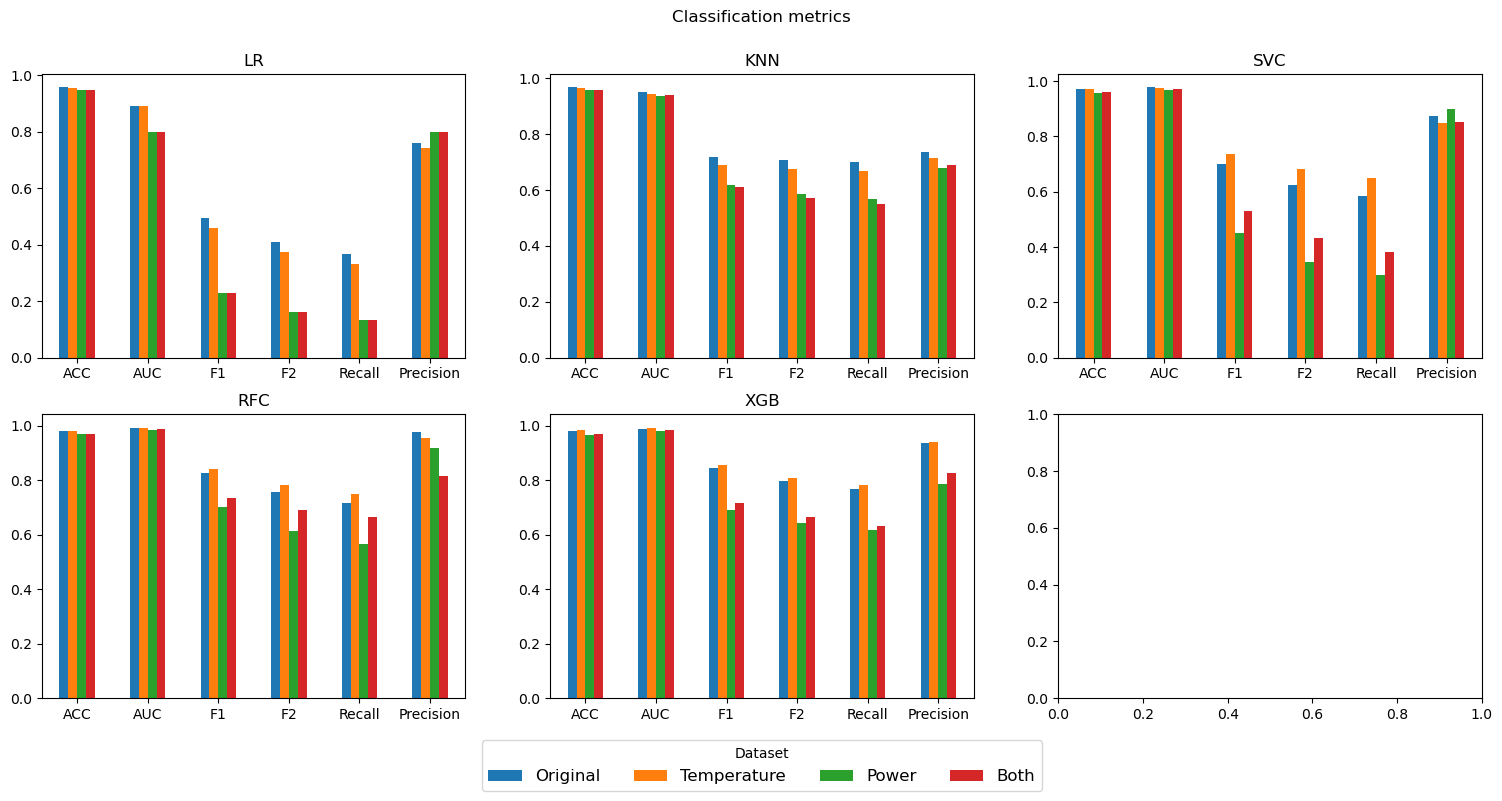

In [55]:
# Models
lr = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC(probability=True)
rfc = RandomForestClassifier()
xgb = XGBClassifier() 

clf = [lr,knn,svc,rfc,xgb]
clf_str = ['LR','KNN','SVC','RFC','XGB'] 

# Fit on raw train
XX_train = X_train.drop(columns=['temp_product','temp_difference','power_output'])
XX_val = X_val.drop(columns=['temp_product','temp_difference','power_output'])
metrics_0 = fit_models(clf, clf_str, XX_train, XX_val, y_train, y_val)

# Fit on temperature product and difference train
XX_train = X_train.drop(columns=['Process temperature _K_','Air temperature _K_','power_output'])
XX_val = X_val.drop(columns=['Process temperature _K_','Air temperature _K_','power_output'])
metrics_1 = fit_models(clf, clf_str, XX_train, XX_val, y_train, y_val)

# Fit on power product train
XX_train = X_train.drop(columns=['Rotational speed _rpm_','Torque _Nm_','temp_product','temp_difference'])
XX_val = X_val.drop(columns=['Rotational speed _rpm_','Torque _Nm_','temp_product','temp_difference'])
metrics_2 = fit_models(clf, clf_str, XX_train, XX_val, y_train, y_val)

# Fit on both products train
XX_train = X_train.drop(columns=['Process temperature _K_','Air temperature _K_','Rotational speed _rpm_','Torque _Nm_'])
XX_val = X_val.drop(columns=['Process temperature _K_','Air temperature _K_','Rotational speed _rpm_','Torque _Nm_'])
metrics_3 = fit_models(clf, clf_str, XX_train, XX_val, y_train, y_val)

# classification metrics barplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,8))
fig.suptitle('Classification metrics')
for j, model in enumerate(clf_str):
    ax = axs[j//3,j-3*(j//3)]
    model_metrics = pd.DataFrame(data=[metrics_0[model],metrics_1[model],metrics_2[model],metrics_3[model]])
    model_metrics.index = ['Original','Temperature','Power','Both']
    model_metrics.transpose().plot(ax=ax, kind='bar', rot=0, )
    ax.title.set_text(model)
    ax.get_legend().remove()
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)
axs.flatten()[-2].legend(title='Dataset', loc='upper center',
                         bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=12)
plt.show()